<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Assignment/sentiment_analysis_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow tensorflow_datasets tensorflow_text zhon bert-for-tf2 sentencepiece
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!git clone https://github.com/cardiffnlp/tweeteval.git

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)
     |████████████████████████████████| 3.7MB 8.8MB/s 
     |████████████████████████████████| 3.4MB 46.1MB/s 
     |████████████████████████████████| 102kB 8.7MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 1.2MB 38.7MB/s 
  Created wheel for zhon: filename=zhon-1.1.5-cp37-none-any.whl size=84291 sha256=4602f1fdea1704ef7ff8c2d0d2eb54e5eb746c3f823f85e2d38068f60d4685b6
  Stored in directory: /root/.cache/pip/wheels/0e/93/5a/ad2f403c359ba996e33c21bf18611d921413df9740ede2fcf4
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=49792e5fb0426c2040331d96953c82439741be2bcd526074792a5998001aaccb
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=59120b29c480ed

In [2]:
from google.colab import output
from google.colab import drive
import os,pathlib,re,nltk,pickle,string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
from tensorflow.keras import Input, layers, losses, preprocessing, utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# ML Libraries
from sklearn.metrics import accuracy_score,confusion_matrix
from zhon import hanzi 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import csv
import tokenization

try:
    %tensorflow_version 2.x
except Exception:
    pass
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Num GPUs Available:  1


In [3]:
# drive.mount('/content/drive/')
base_dir = '/content/tweeteval/datasets/'
hate_dir = base_dir + "hate"
irony_dir = base_dir + "irony"
offensive_dir = base_dir + "offensive"

In [4]:
stop_words = stopwords.words('english')
new_words=['im']
for i in new_words:
  stop_words.append(i) 

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = tweet.translate(str.maketrans('', '', hanzi.punctuation))
    tweet = remove_emoji(tweet)
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens]
    return " ".join(filtered_words)

def readfile(text):
  pd_list = []
  with open(text,'r') as f:
    for tweet in f.read().splitlines():
      tweet = preprocess_tweet_text(tweet)
      pd_list.append(tweet)   
  return pd_list
 
def readfile_label(text):
  pd_list = []
  with open(text,'r') as f:
    for tweet in f.read().splitlines():
      pd_list.append(int(tweet))  
  return pd_list

In [5]:
#Pre-process csv and merge into a Dataframe
#Hate DataFrame Data 
hate_dict_train = {'text': readfile(os.path.join(hate_dir,"train_text.txt")),'label': readfile_label(os.path.join(hate_dir,"train_labels.txt"))}
hate_dict_val = {'text': readfile(os.path.join(hate_dir,"val_text.txt")),'label': readfile_label(os.path.join(hate_dir,"val_labels.txt"))}
hate_dict_test = {'text': readfile(os.path.join(hate_dir,"test_text.txt")),'label': readfile_label(os.path.join(hate_dir,"test_labels.txt"))}
hate_train_df = pd.DataFrame(hate_dict_train)
hate_val_df = pd.DataFrame(hate_dict_val)
hate_test_df = pd.DataFrame(hate_dict_test)
hate_frames = [hate_train_df, hate_val_df, hate_test_df]
df_hate = pd.concat(hate_frames)
not_hate = df_hate[df_hate['label'] == 0]
hate = df_hate[df_hate['label'] == 1]

#Irony DataFrame
irony_dict_train = {'text': readfile(os.path.join(irony_dir,"train_text.txt")),'label': readfile_label(os.path.join(irony_dir,"train_labels.txt"))}
irony_dict_val = {'text': readfile(os.path.join(irony_dir,"val_text.txt")),'label': readfile_label(os.path.join(irony_dir,"val_labels.txt"))}
irony_dict_test = {'text': readfile(os.path.join(irony_dir,"test_text.txt")),'label': readfile_label(os.path.join(irony_dir,"test_labels.txt"))}
irony_train_df = pd.DataFrame(irony_dict_train)
irony_val_df = pd.DataFrame(irony_dict_val)
irony_test_df = pd.DataFrame(irony_dict_test)
irony_frames = [irony_train_df,irony_val_df,irony_test_df]
df_irony = pd.concat(irony_frames)
not_irony  = df_irony[df_irony['label'] == 0]
irony  = df_irony[df_irony['label'] == 1]

#Offensive DataFrame
offensive_dict_train = {'text': readfile(os.path.join(offensive_dir,"train_text.txt")),'label': readfile_label(os.path.join(offensive_dir,"train_labels.txt"))}
offensive_dict_val = {'text': readfile(os.path.join(offensive_dir,"val_text.txt")),'label': readfile_label(os.path.join(offensive_dir,"val_labels.txt"))}
offensive_dict_test = {'text': readfile(os.path.join(offensive_dir,"test_text.txt")),'label': readfile_label(os.path.join(offensive_dir,"test_labels.txt"))}
offensive_train_df = pd.DataFrame(offensive_dict_train)
offensive_val_df = pd.DataFrame(offensive_dict_val)
offensive_test_df = pd.DataFrame(offensive_dict_test)
offensive_frames = [offensive_train_df,offensive_val_df,offensive_test_df]
df_offensive = pd.concat(offensive_frames)
not_offensive  = df_offensive[df_offensive['label'] == 0]
offensive  = df_offensive[df_offensive['label'] == 1]

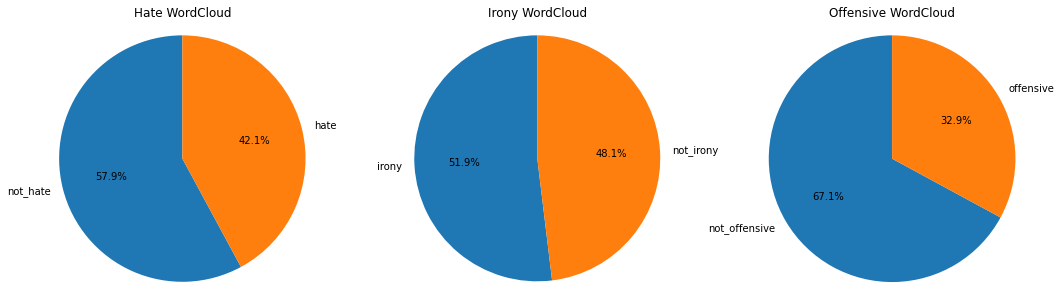

In [6]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(18)

nh_p = len(not_hate) / len(df_hate)
h_p = len(hate) / len(df_hate)
#Hate
h_sizes = [nh_p,h_p]
h_labels = 'not_hate', 'hate'
axs[0].axis('off')
axs[0].set_title("Hate WordCloud")
axs[0].pie(h_sizes, labels=h_labels, autopct='%1.1f%%',startangle=90)
axs[0].axis('equal')

#Irony
ni_p = len(not_irony) / len(df_irony)
i_p = len(irony) / len(df_irony)
i_sizes = [ni_p,i_p]
i_labels = 'irony', 'not_irony'
axs[1].axis('off')
axs[1].set_title("Irony WordCloud")
axs[1].pie(i_sizes, labels=i_labels, autopct='%1.1f%%',startangle=90)
axs[1].axis('equal')

no_p = len(not_offensive) / len(df_offensive)
o_p = len(offensive) / len(df_offensive)
#Offensive
h_sizes = [no_p,o_p]
h_labels = 'not_offensive', 'offensive'
axs[2].axis('off')
axs[2].set_title("Offensive WordCloud")
axs[2].pie(h_sizes, labels=h_labels, autopct='%1.1f%%',startangle=90)
axs[2].axis('equal')

plt.show()

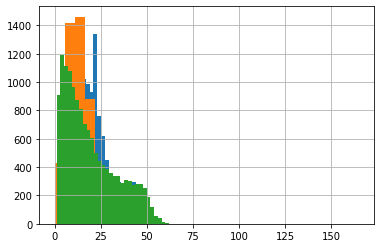

In [7]:
#The length of sentences after tokenization
seq_len = [len(i.split()) for i in df_hate['text']]
pd.Series(seq_len).hist(bins = 30)
seq_len = [len(i.split()) for i in df_irony['text']]
pd.Series(seq_len).hist(bins = 30)
seq_len = [len(i.split()) for i in df_offensive['text']]
pd.Series(seq_len).hist(bins = 30)

In [8]:
#Generate Data for WordCloud
#Hate wordcloud
not_hate_text = " ".join(preprocess_tweet_text(review) for review in not_hate["text"])
hate_text = " ".join(preprocess_tweet_text(review) for review in hate["text"])
wordcloud_not_hate = WordCloud(max_words=100,background_color="grey").generate(not_hate_text)
wordcloud_hate = WordCloud(max_words=100,background_color="grey").generate(hate_text)
#Irony wordcloud
not_irony_text = " ".join(preprocess_tweet_text(review) for review in not_irony["text"])
irony_text = " ".join(preprocess_tweet_text(review) for review in irony["text"])
wordcloud_not_irony = WordCloud().generate(not_irony_text)
wordcloud_irony = WordCloud().generate(irony_text)
#Offensive wordcloud
not_offensive_text = " ".join(preprocess_tweet_text(review) for review in not_offensive["text"])
offensive_text = " ".join(preprocess_tweet_text(review) for review in offensive["text"])
wordcloud_not_offensive = WordCloud(max_words=100,background_color="white").generate(not_offensive_text)
wordcloud_offensive = WordCloud(max_words=100,background_color="white").generate(offensive_text)

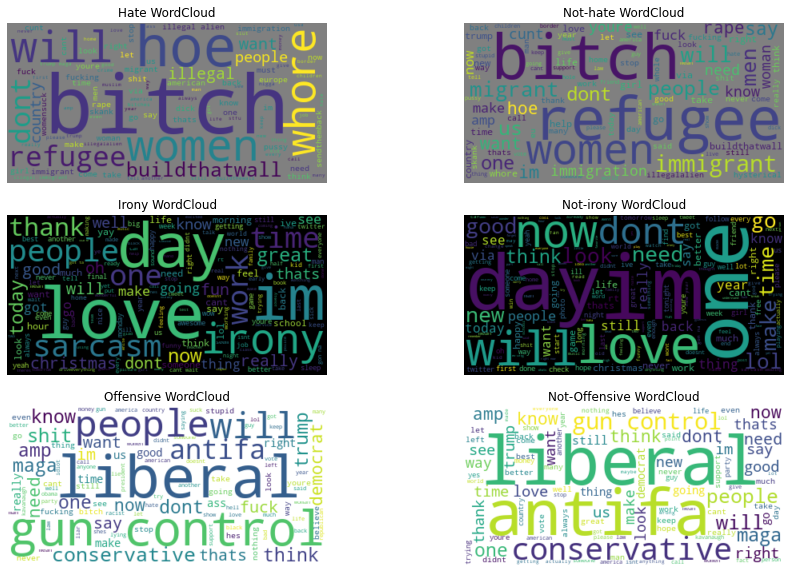

In [9]:
#Wordcloud Plot
fig, axs = plt.subplots(3,2)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0,0].axis('off')
axs[0,0].set_title("Hate WordCloud")
axs[0,0].imshow(wordcloud_hate, interpolation='bilinear')
axs[0,1].set_title("Not-hate WordCloud")
axs[0,1].imshow(wordcloud_not_hate, interpolation='bilinear')
axs[0,1].axis('off')
axs[1,0].set_title("Irony WordCloud")
axs[1,0].imshow(wordcloud_irony, interpolation='bilinear')
axs[1,0].axis('off')
axs[1,1].set_title("Not-irony WordCloud")
axs[1,1].imshow(wordcloud_not_irony, interpolation='bilinear')
axs[1,1].axis('off')
axs[2,0].set_title("Offensive WordCloud")
axs[2,0].imshow(wordcloud_offensive, interpolation='bilinear')
axs[2,0].axis('off')
axs[2,1].set_title("Not-Offensive WordCloud")
axs[2,1].imshow(wordcloud_not_offensive, interpolation='bilinear')
axs[2,1].axis('off')

plt.show()
plt.close()

In [10]:
def bert_encode(texts, tokenizer, max_len=512):
  all_tokens = []
  all_masks = []
  all_segments = []
  for text in texts:
      text = tokenizer.tokenize(text)
      text = text[:max_len-2]
      input_sequence = ["[CLS]"] + text + ["[SEP]"]
      pad_len = max_len - len(input_sequence)
      tokens = tokenizer.convert_tokens_to_ids(input_sequence)
      tokens += [0] * pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0] * max_len
      all_tokens.append(tokens)
      all_masks.append(pad_masks)
      all_segments.append(segment_ids)
  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [11]:
#Create Bert Model
def build_model(bert_layer, max_len=512):
    ids = Input(shape=(max_len,), dtype=tf.int32, name="ids")
    mask = Input(shape=(max_len,), dtype=tf.int32, name="mask")
    seg = Input(shape=(max_len,), dtype=tf.int32, name="seg")
    _, sequence_output = bert_layer([ids, mask, seg])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    model = Model(inputs=[ids, mask, seg], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [13]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 29.9 s, sys: 5.92 s, total: 35.8 s
Wall time: 38.4 s


In [14]:
#Import Bert Tokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [15]:
#Encoding text for hate datasets
ha_train_input = bert_encode(hate_train_df.text, tokenizer, max_len=160)
ha_val_input = bert_encode(hate_val_df.text, tokenizer, max_len=160)
ha_test_input = bert_encode(hate_test_df.text, tokenizer, max_len=160)

In [16]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ids (InputLayer)                [(None, 160)]        0                                            
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 160)]        0                                            
__________________________________________________________________________________________________
seg (InputLayer)                [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   ids[0][0]                        
                                                                 mask[0][0]                   

In [17]:
#Training Hate model
checkpoint = ModelCheckpoint('hate_model.h5', monitor='val_loss', save_best_only=True)
train_history = model.fit(
    ha_train_input, hate_train_df.label,
    validation_data=(ha_val_input, hate_val_df.label),
    epochs=5,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/5
563/563 [==============================] - 569s 940ms/step - loss: 0.5122 - accuracy: 0.7466 - val_loss: 0.5237 - val_accuracy: 0.7390
Epoch 2/5
563/563 [==============================] - 526s 934ms/step - loss: 0.2410 - accuracy: 0.9035 - val_loss: 0.5375 - val_accuracy: 0.7640
Epoch 3/5
563/563 [==============================] - 526s 934ms/step - loss: 0.0475 - accuracy: 0.9854 - val_loss: 0.8749 - val_accuracy: 0.7430
Epoch 4/5
563/563 [==============================] - 526s 935ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 0.9403 - val_accuracy: 0.7490
Epoch 5/5
563/563 [==============================] - 527s 935ms/step - loss: 0.0154 - accuracy: 0.9950 - val_loss: 0.9903 - val_accuracy: 0.7520


In [18]:
from keras import backend as K
K.clear_session()
del model
model = build_model(bert_layer, max_len=160)

model.load_weights('hate_model.h5')
# model.evaluate(test_input, y_test,batch_size=200)
test_pred = model.predict(ha_test_input)
y_pred = [i[0] for i in test_pred.round().astype(int)]
cm = confusion_matrix(hate_test_df.label,y_pred)

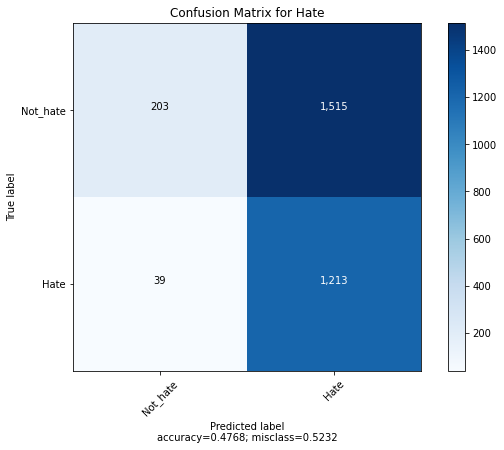

In [19]:
plot_confusion_matrix(cm, normalize=False,target_names=['Not_hate', 'Hate'],title="Confusion Matrix for Hate")

In [20]:
#Encoding text for irony datasets
ir_train_input = bert_encode(irony_train_df.text, tokenizer, max_len=160)
ir_val_input = bert_encode(irony_val_df.text, tokenizer, max_len=160)
ir_test_input = bert_encode(irony_test_df.text, tokenizer, max_len=160)

In [21]:
#Training Irony model
checkpoint = ModelCheckpoint('model_irony.h5', monitor='val_loss', save_best_only=True)
train_history = model.fit(
    ir_train_input, irony_train_df.label,
    validation_data=(ir_val_input, irony_val_df.label),
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/3
179/179 [==============================] - 201s 1s/step - loss: 0.7666 - accuracy: 0.5552 - val_loss: 0.6083 - val_accuracy: 0.6754
Epoch 2/3
179/179 [==============================] - 180s 1s/step - loss: 0.4086 - accuracy: 0.8267 - val_loss: 0.7446 - val_accuracy: 0.6220
Epoch 3/3
179/179 [==============================] - 180s 1s/step - loss: 0.1094 - accuracy: 0.9690 - val_loss: 0.8814 - val_accuracy: 0.6764


In [22]:
model.load_weights('model_irony.h5')
# model.evaluate(test_input, y_test,batch_size=200)
test_pred = model.predict(ir_test_input)
y_pred = [i[0] for i in test_pred.round().astype(int)]
cm = confusion_matrix(irony_test_df.label,y_pred)

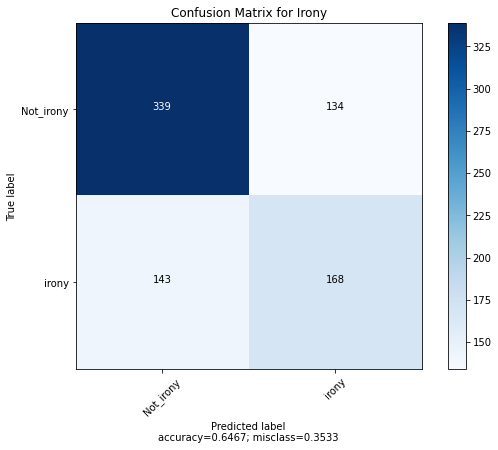

In [23]:
plot_confusion_matrix(cm, normalize=False,target_names=['Not_irony', 'irony'],title="Confusion Matrix for Irony")

In [24]:
#Encoding text for offensive datasets
of_train_input = bert_encode(offensive_train_df.text, tokenizer, max_len=160)
of_val_input = bert_encode(offensive_val_df.text, tokenizer, max_len=160)
of_test_input = bert_encode(offensive_test_df.text, tokenizer, max_len=160)

In [25]:
from keras import backend as K
K.clear_session()
del model
model = build_model(bert_layer, max_len=160)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, min_delta=0.001, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]
train_history = model.fit(
    of_train_input, offensive_train_df.label,
    validation_data=(of_val_input, offensive_val_df.label),
    epochs=3,
    callbacks=callbacks,
    batch_size=16
)

Epoch 1/3
745/745 [==============================] - 720s 941ms/step - loss: 0.4895 - accuracy: 0.7647 - val_loss: 0.4511 - val_accuracy: 0.7863
Epoch 2/3
745/745 [==============================] - 698s 937ms/step - loss: 0.3044 - accuracy: 0.8718 - val_loss: 0.5137 - val_accuracy: 0.7855
Epoch 3/3
745/745 [==============================] - 698s 937ms/step - loss: 0.0961 - accuracy: 0.9668 - val_loss: 0.8260 - val_accuracy: 0.7764


In [26]:
model.load_weights('model_offensive.h5')
# model.evaluate(test_input, y_test,batch_size=200)
test_pred = model.predict(of_test_input)
y_pred = [i[0] for i in test_pred.round().astype(int)]
cm = confusion_matrix(offensive_test_df.label,y_pred)

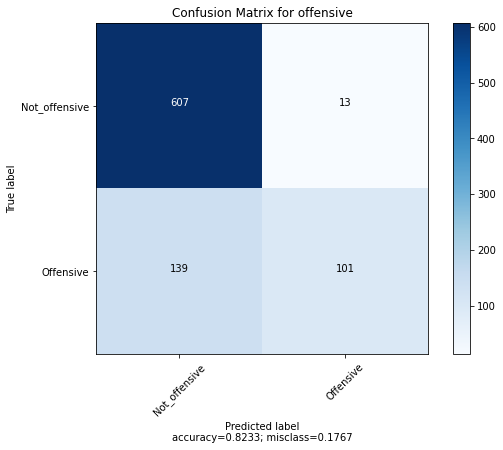

In [27]:
plot_confusion_matrix(cm, normalize=False,target_names=['Not_offensive', 'Offensive'],title="Confusion Matrix for offensive")